<a href="https://colab.research.google.com/github/jkjh23/BusanAIDeveloperCourse_AI/blob/master/1_Analysis/6-1_%EB%8D%B0%EC%9D%B4%ED%84%B0%20%EB%B6%84%EC%84%9D_%EC%8B%A4%EB%8D%B0%EC%9D%B4%ED%84%B0%20%EC%9D%B4%EC%9A%A9_%EC%9D%B8%EA%B5%AC%ED%86%B5%EA%B3%84%2B%EA%B8%B0%ED%83%80%EC%A0%95%EB%B3%B4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

# 한글 처리 (구글링)
%config InlineBackend.figure_format = 'retina'
 
!apt -qq -y install fonts-nanum
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 22 not upgraded.


# 연구목표
- 인구 통계 데이터를 이용해 다른 지표와 연계, 결합, 상관성을 분석하여 결과를 도출
- 대상 지역은 서울(기타 지표 데이터가 가장 多)
  - 시도 → 서울(차후에 가능성 열어두고 부산도 검토)
  - 시군구 → 구 : 기준 지점(구 단위)
  - 읍면동 → 동
- 지도상에 행정구역을 표현, colormap으로 밀도 표현, 연관 지표를 연계해 **상관성**에 대한 시각적 표현 수행
- 인구 통계 연관시키는 데이터
  - 부동산(가격추이, 매물, 국가정책 → 국토부, 렌트홈), 가구수, 유동인구, 출생신고, 평일 거주자/실 거주자, 소비 발생(카드사 정보), 음식물 쓰레기 등
  - 범죄율  
  → 경찰서 → 범죄 발생과 관련된 데이터   
  → 범죄 예방에 대한 방안 → CCTV
  - 인구 소멸 → 논문 → 19~29세 여성 / 60세 이상 노인 비율
  - [선거](https://www.nec.go.kr/portal/main.do)
  - 주장에 대한 아이디어는 논문은 [dbpia](https://www.dbpia.co.kr/)에서 해결 → 일종의 사회과약 분야 

# 데이터 수집
- 대상 : 서울
  - 인구통계 데이터
  - cctv 데이터
    - [서울 열린데이터광장](https://data.seoul.go.kr/)
    - 검색어
      - [인구통계](https://data.seoul.go.kr/dataList/419/S/2/datasetView.do) : 13~19년, txt
      - [cctv](https://data.seoul.go.kr/dataList/OA-2734/C/1/datasetView.do) : ~18년, xlsx
  - 경찰서 위치 정보 데이터
    - 카카오 api를 이용해 동적 획득
  - 행정구역 표시를 위한 gps 정보(시군구 단위)
    - 보유!
    - GIS(지리정보 시각화)
    - folium
  - 저작권 표시
    - 해당 데이터에 표시가 되어 있음(공공/연구 등 제공데이터)
    - 만약 수집하는 데이터라면 상용화는 법률 검토 필요

  - 데이터는 공공 데이터에서 제공받음
    - 적용 : level1
    - 기타 : gps, 행정구역 정보는 차후에 사용하는 시점에서 획득

# 데이터 준비

- 데이터 품질 향상
- 전처리, 적재, 파생변수(분석하면서도 등장) 등 생성
- 정규화! / 데이터의 이진화(0 혹은 1로 표현)


In [2]:
import pandas as pd
import numpy as np

In [3]:
# 인구 통계 데이터 로드

# 파일을 열어보니 csv형식인데, 구분자를 tab으로 사용
# 데이터 로드 → DataFrame으로 생성
path = "/content/drive/My Drive/2020_AI_Busan/1_Analysis/data/report.txt"
s_pop = pd.read_csv(path, sep="\t", encoding="UTF-8")
s_pop.head()
# 주어진 데이터의 column 파트가 3개 라인을 사용하고 있어서 실제 데이터가 아닌 부분도 데이터로 표현됨
# 읽을 때 헤더 부분에 대한 지정

,기간,자치구,세대,인구,인구.1,인구.2,인구.3,인구.4,인구.5,인구.6,인구.7,인구.8,인구밀도,인구밀도.1,세대당인구,65세이상고령자
0,기간,자치구,세대,합계,합계,합계,한국인,한국인,한국인,등록외국인,등록외국인,등록외국인,인구밀도,인구밀도,세대당인구,65세이상고령자
1,기간,자치구,세대,계,남자,여자,계,남자,여자,계,남자,여자,인구밀도(명/㎢),면적(㎢),세대당인구,65세이상고령자
2,2013,합계,"4,182,351","10,388,055","5,126,351","5,261,704","10,143,645","5,007,869","5,135,776","244,410","118,482","125,928","17,165",605.2,2.43,"1,167,177"
3,2013,종로구,"73,693","167,867","83,211","84,656","160,070","79,519","80,551","7,797","3,692","4,105","7,022",23.91,2.17,"23,997"
4,2013,중구,"60,600","137,990","69,128","68,862","130,465","65,371","65,094","7,525","3,757","3,768","13,854",9.96,2.15,"19,346"


In [4]:
# 사전에 데이터 헤더 쪽에 대한 이해를 가진 상태에서 진행해야 각 column의 의미를 알게 됨
s_pop = pd.read_csv(path, sep="\t", encoding="UTF-8", header=2)
s_pop.head()

,기간,자치구,세대,계,남자,여자,계.1,남자.1,여자.1,계.2,남자.2,여자.2,인구밀도(명/㎢),면적(㎢),세대당인구,65세이상고령자
0,2013,합계,"4,182,351","10,388,055","5,126,351","5,261,704","10,143,645","5,007,869","5,135,776","244,410","118,482","125,928","17,165",605.2,2.43,"1,167,177"
1,2013,종로구,"73,693","167,867","83,211","84,656","160,070","79,519","80,551","7,797","3,692","4,105","7,022",23.91,2.17,"23,997"
2,2013,중구,"60,600","137,990","69,128","68,862","130,465","65,371","65,094","7,525","3,757","3,768","13,854",9.96,2.15,"19,346"
3,2013,용산구,"109,361","251,925","122,974","128,951","239,740","116,491","123,249","12,185","6,483","5,702","11,520",21.87,2.19,"34,017"
4,2013,성동구,"126,447","306,571","152,809","153,762","299,337","149,304","150,033","7,234","3,505","3,729","18,190",16.85,2.37,"35,421"


In [5]:
# column 중에서 성별 구분이 아니라, 총계만 필요
# s_pop = pd.read_csv(path, sep="\t", encoding="UTF-8", header=2, usecols=["A", "B", "C", "D", "G", "J", "M", "N"])? 또는 ['A, B, C']? 
# → csv/엑셀 형식으로 올리면 ABC...로
s_pop = pd.read_csv(path, sep="\t", encoding="UTF-8", header=2, usecols=[0, 1, 2, 3, 6, 9, 14, 15])
s_pop.head()

,기간,자치구,세대,계,계.1,계.2,세대당인구,65세이상고령자
0,2013,합계,"4,182,351","10,388,055","10,143,645","244,410",2.43,"1,167,177"
1,2013,종로구,"73,693","167,867","160,070","7,797",2.17,"23,997"
2,2013,중구,"60,600","137,990","130,465","7,525",2.15,"19,346"
3,2013,용산구,"109,361","251,925","239,740","12,185",2.19,"34,017"
4,2013,성동구,"126,447","306,571","299,337","7,234",2.37,"35,421"


In [6]:
# cctv 데이터 로드
path = "/content/drive/My Drive/2020_AI_Busan/1_Analysis/data/cctv.xlsx"
s_cctv = pd.read_excel(path)
s_cctv.head()

,기관명,소계,2011년 이전,2012년,2013년,2014년,2015년,2016년,2017년,2018년
0,강 남 구,5221,1944.0,195.0,316.0,430,546,765,577,448
1,강 동 구,1879,303.0,387.0,134.0,59,144,194,273,385
2,강 북 구,1265,243.0,88.0,141.0,74,145,254,1,319
3,강 서 구,1617,219.0,155.0,118.0,230,187,190,264,254
4,관 악 구,3985,430.0,56.0,419.0,487,609,619,694,671


## DataFrame 조정
- column 중 적절하지 않은 내용 수정

In [7]:
s_pop.columns
# Index(['기간', '자치구', '세대', '계', '계.1', '계.2', '세대당인구', '65세이상고령자']

Index(['기간', '자치구', '세대', '계', '계.1', '계.2', '세대당인구', '65세이상고령자'], dtype='object')

In [8]:
# '연도', '자치구', '세대수', '총인구수', '한국인', '외국인', '세대당인구', '고령자(65)'
s_pop.columns = ['연도', '자치구', '세대수', '총인구수', '한국인', '외국인', '세대당인구', '고령자(65)']
s_pop.head(2)

,연도,자치구,세대수,총인구수,한국인,외국인,세대당인구,고령자(65)
0,2013,합계,"4,182,351","10,388,055","10,143,645","244,410",2.43,"1,167,177"
1,2013,종로구,"73,693","167,867","160,070","7,797",2.17,"23,997"


In [9]:
# column 부분 변경
s_cctv.columns
# Index(['기관명', '소계', '2011년 이전', '2012년', '2013년', '2014년', '2015년', '2016년', '2017년', '2018년']

Index(['기관명', '소계', '2011년 이전', '2012년', '2013년', '2014년', '2015년', '2016년',
       '2017년', '2018년'],
      dtype='object')

In [10]:
# '기관명' → '자치구'
# '2011년 이전' → '2011년'
# 변경되는 패턴 → 키(원래값):값(변경될 값)
dic = {
    s_cctv.columns[0] : '자치구',
    s_cctv.columns[2] : '2011년'
}
# inplace = True 하면 원본 반영
s_cctv.rename( columns = dic, inplace = True )
s_cctv.columns

Index(['자치구', '소계', '2011년', '2012년', '2013년', '2014년', '2015년', '2016년',
       '2017년', '2018년'],
      dtype='object')

# 데이터 분석
- 통찰 및 분석

In [11]:
# s_cctv 데이터 살펴보기
s_cctv

,자치구,소계,2011년,2012년,2013년,2014년,2015년,2016년,2017년,2018년
0,강 남 구,5221,1944.0,195.0,316.0,430,546,765,577,448
1,강 동 구,1879,303.0,387.0,134.0,59,144,194,273,385
2,강 북 구,1265,243.0,88.0,141.0,74,145,254,1,319
3,강 서 구,1617,219.0,155.0,118.0,230,187,190,264,254
4,관 악 구,3985,430.0,56.0,419.0,487,609,619,694,671
5,광 진 구,1581,470.0,42.0,83.0,87,64,21,468,346
6,구 로 구,3227,852.0,219.0,349.0,187,268,326,540,486
7,금 천 구,1634,27.0,17.0,242.0,101,382,136,199,530
8,노 원 구,1906,481.0,117.0,203.0,80,461,298,110,156
9,도 봉 구,858,197.0,66.0,8.0,185,59,155,117,71


In [12]:
s_cctv.shape

(25, 10)

In [13]:
# 서울시 자치구의 총개수는 25개
GU_COUNTS = s_cctv.shape[0]
GU_COUNTS

25

In [14]:
# column
# 연도별 증가 비율, 특정 연도 기준으로 검토 可, 총량/개별 증가량이 존재
s_cctv.head(2)

,자치구,소계,2011년,2012년,2013년,2014년,2015년,2016년,2017년,2018년
0,강 남 구,5221,1944.0,195.0,316.0,430,546,765,577,448
1,강 동 구,1879,303.0,387.0,134.0,59,144,194,273,385


In [15]:
# 정렬을 통해서 자치구별 비교
# 소계 기준으로 CCTV가 가장 많이 설치된 순으로 정렬하고, 상위 5개, 하위 5개 출력
s_cctv.sort_values( by = '소계', ascending = False).head()

,자치구,소계,2011년,2012년,2013년,2014년,2015년,2016년,2017년,2018년
0,강 남 구,5221,1944.0,195.0,316.0,430,546,765,577,448
4,관 악 구,3985,430.0,56.0,419.0,487,609,619,694,671
6,구 로 구,3227,852.0,219.0,349.0,187,268,326,540,486
16,성 북 구,3003,779.0,84.0,304.0,241,279,388,285,643
21,은 평 구,2962,1365.0,83.0,99.0,343,180,296,229,367


In [16]:
s_cctv.sort_values( by = '소계', ascending = False).tail()

,자치구,소계,2011년,2012년,2013년,2014년,2015년,2016년,2017년,2018년
23,중 구,1544,25.0,165.0,114.0,80,245,270,317,328
22,종 로 구,1471,8.0,7.0,599.0,132,195,148,281,101
2,강 북 구,1265,243.0,88.0,141.0,74,145,254,1,319
24,중 랑 구,1068,NaN,NaN,NaN,770,102,121,66,9
9,도 봉 구,858,197.0,66.0,8.0,185,59,155,117,71


In [17]:
# 2011년 이후로 cctv가 늘어난 비율, 증가분에 대한 계산 → 파생변수 생성
# 2015년 기준 최근 3년간 증가한 비율 계산 → (2016~2018) / (2015) * 100
# column명은 3년간증가분
# s_cctv["3년간증가분"] = (s_cctv.iloc[:, 7] + s_cctv.iloc[:, 8] + s_cctv.iloc[:, 9]) / s_cctv.iloc[:, 6] * 100

In [18]:
s_cctv.dtypes

자치구       object
소계         int64
2011년    float64
2012년    float64
2013년    float64
2014년      int64
2015년      int64
2016년      int64
2017년      int64
2018년      int64
dtype: object

In [19]:
(s_cctv['2016년']+s_cctv['2017년']+s_cctv['2018년'])/s_cctv['2015년']*100

0      327.838828
1      591.666667
2      395.862069
3      378.609626
4      325.779967
5     1304.687500
6      504.477612
7      226.439791
8      122.342733
9      581.355932
10     509.909910
11     605.384615
12     523.163842
13     812.844037
14     462.790698
15     553.488372
16     471.684588
17     368.674699
18     765.116279
19     396.994536
20     217.647059
21     495.555556
22     271.794872
23     373.469388
24     192.156863
dtype: float64

In [20]:
# 매년 데이터가 추가된다면 매번 고정값을 수정할 것인가
# 고정값을 제외하고 자동으로 계산된다면
# 최근 3년 내에 증가분을 데이터가 추가되더라도 문제없이 처리 가능 → 일반화, 재사용성 ↑
# 최초 수행했을 때만 적용됨
# 수행 방향에 따라가 오류가 될 수도 있으므로, 주의 혹은 보정(정방향), 컬럼명으로 수행

def makeLastYearIncreaseRate(period = 3) : 
  return np.sum(s_cctv[ s_cctv.columns[ -1 * period : ] ], axis = 1) / s_cctv[ s_cctv.columns[ -1 * period - 1 ] ] * 100

makeLastYearIncreaseRate(3)

0      327.838828
1      591.666667
2      395.862069
3      378.609626
4      325.779967
5     1304.687500
6      504.477612
7      226.439791
8      122.342733
9      581.355932
10     509.909910
11     605.384615
12     523.163842
13     812.844037
14     462.790698
15     553.488372
16     471.684588
17     368.674699
18     765.116279
19     396.994536
20     217.647059
21     495.555556
22     271.794872
23     373.469388
24     192.156863
dtype: float64

In [21]:
s_cctv["3년간증가분"] = makeLastYearIncreaseRate(3)
s_cctv.head(2)

,자치구,소계,2011년,2012년,2013년,2014년,2015년,2016년,2017년,2018년,3년간증가분
0,강 남 구,5221,1944.0,195.0,316.0,430,546,765,577,448,327.838828
1,강 동 구,1879,303.0,387.0,134.0,59,144,194,273,385,591.666667


In [22]:
# 2011-2015를 전체합산 기준값으로 정의해서 최근 3년간 증가분 계산
# 주의사항 : 결측치, 타입 다름
s_cctv.tail()

,자치구,소계,2011년,2012년,2013년,2014년,2015년,2016년,2017년,2018년,3년간증가분
20,용 산 구,2063,1279.0,152.0,201.0,107,102,89,60,73,217.647059
21,은 평 구,2962,1365.0,83.0,99.0,343,180,296,229,367,495.555556
22,종 로 구,1471,8.0,7.0,599.0,132,195,148,281,101,271.794872
23,중 구,1544,25.0,165.0,114.0,80,245,270,317,328,373.469388
24,중 랑 구,1068,NaN,NaN,NaN,770,102,121,66,9,192.156863


In [23]:
# 결측치 : 채우기, 대체하기, 제거하기
# 본 데이터 특성상 데이터를 불러올 때 처리하지 않았고, 데이터를 제거하면 자치구가 사라지므로, 대체하기만 可 → 0 (통계데이터 없다고 간주, 0으로 설정)
s_cctv.fillna(0, inplace = True)
# s_cctv = s_cctv.fillna(0)
s_cctv.tail()

,자치구,소계,2011년,2012년,2013년,2014년,2015년,2016년,2017년,2018년,3년간증가분
20,용 산 구,2063,1279.0,152.0,201.0,107,102,89,60,73,217.647059
21,은 평 구,2962,1365.0,83.0,99.0,343,180,296,229,367,495.555556
22,종 로 구,1471,8.0,7.0,599.0,132,195,148,281,101,271.794872
23,중 구,1544,25.0,165.0,114.0,80,245,270,317,328,373.469388
24,중 랑 구,1068,0.0,0.0,0.0,770,102,121,66,9,192.156863


In [24]:
# 2011 - 2015 합산

# 최근 3년 컬럼
target_year = s_cctv.columns[-1*3-1:-1]
# 비교 기준 컬럼
std_yesr = s_cctv.columns[2:7]
# 기준 대비 최근 3년간 증가한 증가분 비교
s_cctv['증가분'] = np.sum(s_cctv[ target_year ], axis = 1) / np.sum(s_cctv[ std_yesr ], axis = 1) * 100
s_cctv

,자치구,소계,2011년,2012년,2013년,2014년,2015년,2016년,2017년,2018년,3년간증가분,증가분
0,강 남 구,5221,1944.0,195.0,316.0,430,546,765,577,448,327.838828,52.171379
1,강 동 구,1879,303.0,387.0,134.0,59,144,194,273,385,591.666667,82.960078
2,강 북 구,1265,243.0,88.0,141.0,74,145,254,1,319,395.862069,83.068017
3,강 서 구,1617,219.0,155.0,118.0,230,187,190,264,254,378.609626,77.887789
4,관 악 구,3985,430.0,56.0,419.0,487,609,619,694,671,325.779967,99.150425
5,광 진 구,1581,470.0,42.0,83.0,87,64,21,468,346,1304.687500,111.930295
6,구 로 구,3227,852.0,219.0,349.0,187,268,326,540,486,504.477612,72.106667
7,금 천 구,1634,27.0,17.0,242.0,101,382,136,199,530,226.439791,112.483745
8,노 원 구,1906,481.0,117.0,203.0,80,461,298,110,156,122.342733,42.026826
9,도 봉 구,858,197.0,66.0,8.0,185,59,155,117,71,581.355932,66.601942


In [25]:
# 3년간 증가분 column을 제거
try :
  del s_cctv['3년간증가분']
except Exception as e:
  pass

In [26]:
# 인구 현황 확인
s_pop.head()

,연도,자치구,세대수,총인구수,한국인,외국인,세대당인구,고령자(65)
0,2013,합계,"4,182,351","10,388,055","10,143,645","244,410",2.43,"1,167,177"
1,2013,종로구,"73,693","167,867","160,070","7,797",2.17,"23,997"
2,2013,중구,"60,600","137,990","130,465","7,525",2.15,"19,346"
3,2013,용산구,"109,361","251,925","239,740","12,185",2.19,"34,017"
4,2013,성동구,"126,447","306,571","299,337","7,234",2.37,"35,421"


In [27]:
# 7*(25+1) = 182 
# 연도 * (자치구 + 합계) = len(s_pop['연도].unique()) * len(s_pop['자치구'].unique) = 182
s_pop.shape

(182, 8)

In [28]:
# 2018년도 데이터만 집계
s_pop_2018 = s_pop[ s_pop['연도'] == 2018 ]
s_pop_2018.shape

(26, 8)

In [29]:
s_pop_2018

,연도,자치구,세대수,총인구수,한국인,외국인,세대당인구,고령자(65)
130,2018,합계,"4,263,868","10,049,607","9,765,623","283,984",2.29,"1,416,131"
131,2018,종로구,"73,735","163,026","153,065","9,961",2.08,"26,742"
132,2018,중구,"61,502","135,633","125,725","9,908",2.04,"22,005"
133,2018,용산구,"108,974","245,090","228,999","16,091",2.10,"37,640"
134,2018,성동구,"137,209","316,463","308,221","8,242",2.25,"42,767"
135,2018,광진구,"162,606","371,063","355,559","15,504",2.19,"45,619"
136,2018,동대문구,"161,820","364,338","348,052","16,286",2.15,"57,165"
137,2018,중랑구,"180,511","408,147","403,209","4,938",2.23,"61,830"
138,2018,성북구,"186,601","447,687","435,868","11,819",2.34,"67,782"
139,2018,강북구,"143,395","322,915","319,164","3,751",2.23,"58,196"


In [30]:
# s_pop_2018에서 합계 데이터를 제거 → 인덱스 제거
# s_pop_2018.drop( [컬럼값 혹은 인덱스값], inplace = 원본반영여부 )
# 130은 합계 데이터를 가리키는 인덱스값
s_pop_2018.drop( [130], inplace = True )
s_pop_2018.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4169: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,연도,자치구,세대수,총인구수,한국인,외국인,세대당인구,고령자(65)
131,2018,종로구,"73,735","163,026","153,065","9,961",2.08,"26,742"
132,2018,중구,"61,502","135,633","125,725","9,908",2.04,"22,005"
133,2018,용산구,"108,974","245,090","228,999","16,091",2.10,"37,640"
134,2018,성동구,"137,209","316,463","308,221","8,242",2.25,"42,767"
135,2018,광진구,"162,606","371,063","355,559","15,504",2.19,"45,619"


In [31]:
s_pop_2018.shape

(25, 8)

In [32]:
# 향후 데이터의 키가 해당되는 컬럼의 중복성 검사
s_pop_2018.자치구.unique(), len(s_pop_2018['자치구'].unique())
# shape상에서 데이터 개수와, 중복을 제거한 데이터의 개수가 동일

(array(['종로구', '중구', '용산구', '성동구', '광진구', '동대문구', '중랑구', '성북구', '강북구',
        '도봉구', '노원구', '은평구', '서대문구', '마포구', '양천구', '강서구', '구로구', '금천구',
        '영등포구', '동작구', '관악구', '서초구', '강남구', '송파구', '강동구'], dtype=object), 25)

In [33]:
# 결측치 검사
s_pop_2018.자치구.isnull()

131    False
132    False
133    False
134    False
135    False
136    False
137    False
138    False
139    False
140    False
141    False
142    False
143    False
144    False
145    False
146    False
147    False
148    False
149    False
150    False
151    False
152    False
153    False
154    False
155    False
Name: 자치구, dtype: bool

In [34]:
# 특정 컬럼에 결측이 존재하면 분기 처리하는 기본 형
tmp = s_pop_2018[ s_pop_2018.자치구.isnull() ].index

if tmp.any() :
  print("결측 존재")
else :
  print("결측 존재하지 않음")

결측 존재하지 않음


In [35]:
s_pop_2018.dtypes
# 수치 부분에 콤마 존재해서 전부 문자열로 처리되어 있음
# 향후 수치 계산을 한다면 정수화 처리가 필요

연도           int64
자치구         object
세대수         object
총인구수        object
한국인         object
외국인         object
세대당인구      float64
고령자(65)     object
dtype: object

In [36]:
s_pop_2018.columns

Index(['연도', '자치구', '세대수', '총인구수', '한국인', '외국인', '세대당인구', '고령자(65)'], dtype='object')

In [37]:
# 함수 : 문자열 → 콤마 제거 → 정수화 → 리턴
def changeIntStr( x = "9,961" ) :
  return int(x.replace(",", ""))

changeIntStr(), type(changeIntStr())

(9961, int)

In [38]:
# 특정 컬럼에 데이터를 하나씩 접근해서 조작(전처리 수행) → 다시 세팅/설정/치환
# pd.apply(DataFrame)으로 나가는 방식도 있음
s_pop_2018["외국인"].apply( changeIntStr ).head()

131     9961
132     9908
133    16091
134     8242
135    15504
Name: 외국인, dtype: int64

In [39]:
# lambda 함수는 수행문이 반드시 1개여야 함
# 2줄이 넘어가면 사용자 정의 함수로 대체해야 함
s_pop_2018["외국인"] = s_pop_2018["외국인"].apply( lambda x : int(x.replace(",", "")) )
s_pop_2018

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,연도,자치구,세대수,총인구수,한국인,외국인,세대당인구,고령자(65)
131,2018,종로구,"73,735","163,026","153,065",9961,2.08,"26,742"
132,2018,중구,"61,502","135,633","125,725",9908,2.04,"22,005"
133,2018,용산구,"108,974","245,090","228,999",16091,2.10,"37,640"
134,2018,성동구,"137,209","316,463","308,221",8242,2.25,"42,767"
135,2018,광진구,"162,606","371,063","355,559",15504,2.19,"45,619"
136,2018,동대문구,"161,820","364,338","348,052",16286,2.15,"57,165"
137,2018,중랑구,"180,511","408,147","403,209",4938,2.23,"61,830"
138,2018,성북구,"186,601","447,687","435,868",11819,2.34,"67,782"
139,2018,강북구,"143,395","322,915","319,164",3751,2.23,"58,196"
140,2018,도봉구,"138,087","341,649","339,413",2236,2.46,"55,964"


In [40]:
s_pop_2018.dtypes

연도           int64
자치구         object
세대수         object
총인구수        object
한국인         object
외국인          int64
세대당인구      float64
고령자(65)     object
dtype: object

In [41]:
# df에서 같은 타입만 모아라
cols = s_pop_2018.select_dtypes( include = 'object' ).columns[1:]
cols

Index(['세대수', '총인구수', '한국인', '고령자(65)'], dtype='object')

In [42]:
# s_pop_2018["세대수"] = s_pop_2018["세대수"].apply( lambda x : int(x.replace(",", "")) )
# s_pop_2018["총인구수"] = s_pop_2018["총인구수"].apply( lambda x : int(x.replace(",", "")) )
# s_pop_2018["한국인"] = s_pop_2018["한국인"].apply( lambda x : int(x.replace(",", "")) )
# s_pop_2018["고령자(65)"] = s_pop_2018["고령자(65)"].apply( lambda x : int(x.replace(",", "")) )

for col in cols :
  s_pop_2018[ col ] = s_pop_2018[ col ].apply( changeIntStr )

s_pop_2018

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,연도,자치구,세대수,총인구수,한국인,외국인,세대당인구,고령자(65)
131,2018,종로구,73735,163026,153065,9961,2.08,26742
132,2018,중구,61502,135633,125725,9908,2.04,22005
133,2018,용산구,108974,245090,228999,16091,2.10,37640
134,2018,성동구,137209,316463,308221,8242,2.25,42767
135,2018,광진구,162606,371063,355559,15504,2.19,45619
136,2018,동대문구,161820,364338,348052,16286,2.15,57165
137,2018,중랑구,180511,408147,403209,4938,2.23,61830
138,2018,성북구,186601,447687,435868,11819,2.34,67782
139,2018,강북구,143395,322915,319164,3751,2.23,58196
140,2018,도봉구,138087,341649,339413,2236,2.46,55964


In [43]:
s_pop_2018.dtypes

연도           int64
자치구         object
세대수          int64
총인구수         int64
한국인          int64
외국인          int64
세대당인구      float64
고령자(65)      int64
dtype: object

In [44]:
# column의 dtype을 조사해서 해당 타입으로 분할
# object → 문자열, 조사

In [45]:
# 전체 인구를 이용해 외국인 비율, 고령자 비율 계산
# 외국인 비율 = 외국인 / 전체 인구 * 100
# 고령자 비율 = 고령자 / 전체 인구 * 100

s_pop_2018['외국인비율'] = s_pop_2018['외국인']     / s_pop_2018['총인구수'] * 100
s_pop_2018['고령자비율'] = s_pop_2018['고령자(65)'] / s_pop_2018['총인구수'] * 100

s_pop_2018.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,연도,자치구,세대수,총인구수,한국인,외국인,세대당인구,고령자(65),외국인비율,고령자비율
131,2018,종로구,73735,163026,153065,9961,2.08,26742,6.110068,16.403518
132,2018,중구,61502,135633,125725,9908,2.04,22005,7.305007,16.223928
133,2018,용산구,108974,245090,228999,16091,2.10,37640,6.565343,15.357624
134,2018,성동구,137209,316463,308221,8242,2.25,42767,2.604412,13.514060
135,2018,광진구,162606,371063,355559,15504,2.19,45619,4.178266,12.294139


In [46]:
# 인구수로 정렬, 상위 3개
s_pop_2018.sort_values( by = '총인구수', ascending = False ).head(3)

,연도,자치구,세대수,총인구수,한국인,외국인,세대당인구,고령자(65),외국인비율,고령자비율
154,2018,송파구,270866,673507,666635,6872,2.46,81364,1.020331,12.080647
146,2018,강서구,258503,603611,596949,6662,2.31,79660,1.103691,13.197241
141,2018,노원구,217655,548160,543752,4408,2.50,77096,0.804145,14.064507


In [47]:
# 외국인 비율로 정렬, 상위 3개
s_pop_2018.sort_values('외국인비율', ascending=False).head(3)

,연도,자치구,세대수,총인구수,한국인,외국인,세대당인구,고령자(65),외국인비율,고령자비율
149,2018,영등포구,171085,403600,367778,35822,2.15,55673,8.875619,13.794103
148,2018,금천구,107971,254021,233917,20104,2.17,35739,7.914306,14.069309
147,2018,구로구,172457,438486,404497,33989,2.35,61801,7.751445,14.094179


In [48]:
# 고령자 비율로 정렬, 상위 3개
s_pop_2018.sort_values('고령자비율', ascending=False).head(3)

,연도,자치구,세대수,총인구수,한국인,외국인,세대당인구,고령자(65),외국인비율,고령자비율
139,2018,강북구,143395,322915,319164,3751,2.23,58196,1.161606,18.022080
131,2018,종로구,73735,163026,153065,9961,2.08,26742,6.110068,16.403518
140,2018,도봉구,138087,341649,339413,2236,2.46,55964,0.654473,16.380554


## 시각화
- 바 차트를 통해서 해당 기준으로 정렬된 자치구의 비교값들을 시각적으로 확인 可

In [49]:
# colab에서만 적용
%config InlineBackend.figure_format = 'retina'
!apt -qq -y install fonts-nanum

fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 22 not upgraded.


In [50]:
# 시각화 준비
import matplotlib.pyplot as plt

# 빌트인
%matplotlib inline

# 한글화
# from korean_font import initKoreaFont
# initKoreaFont()

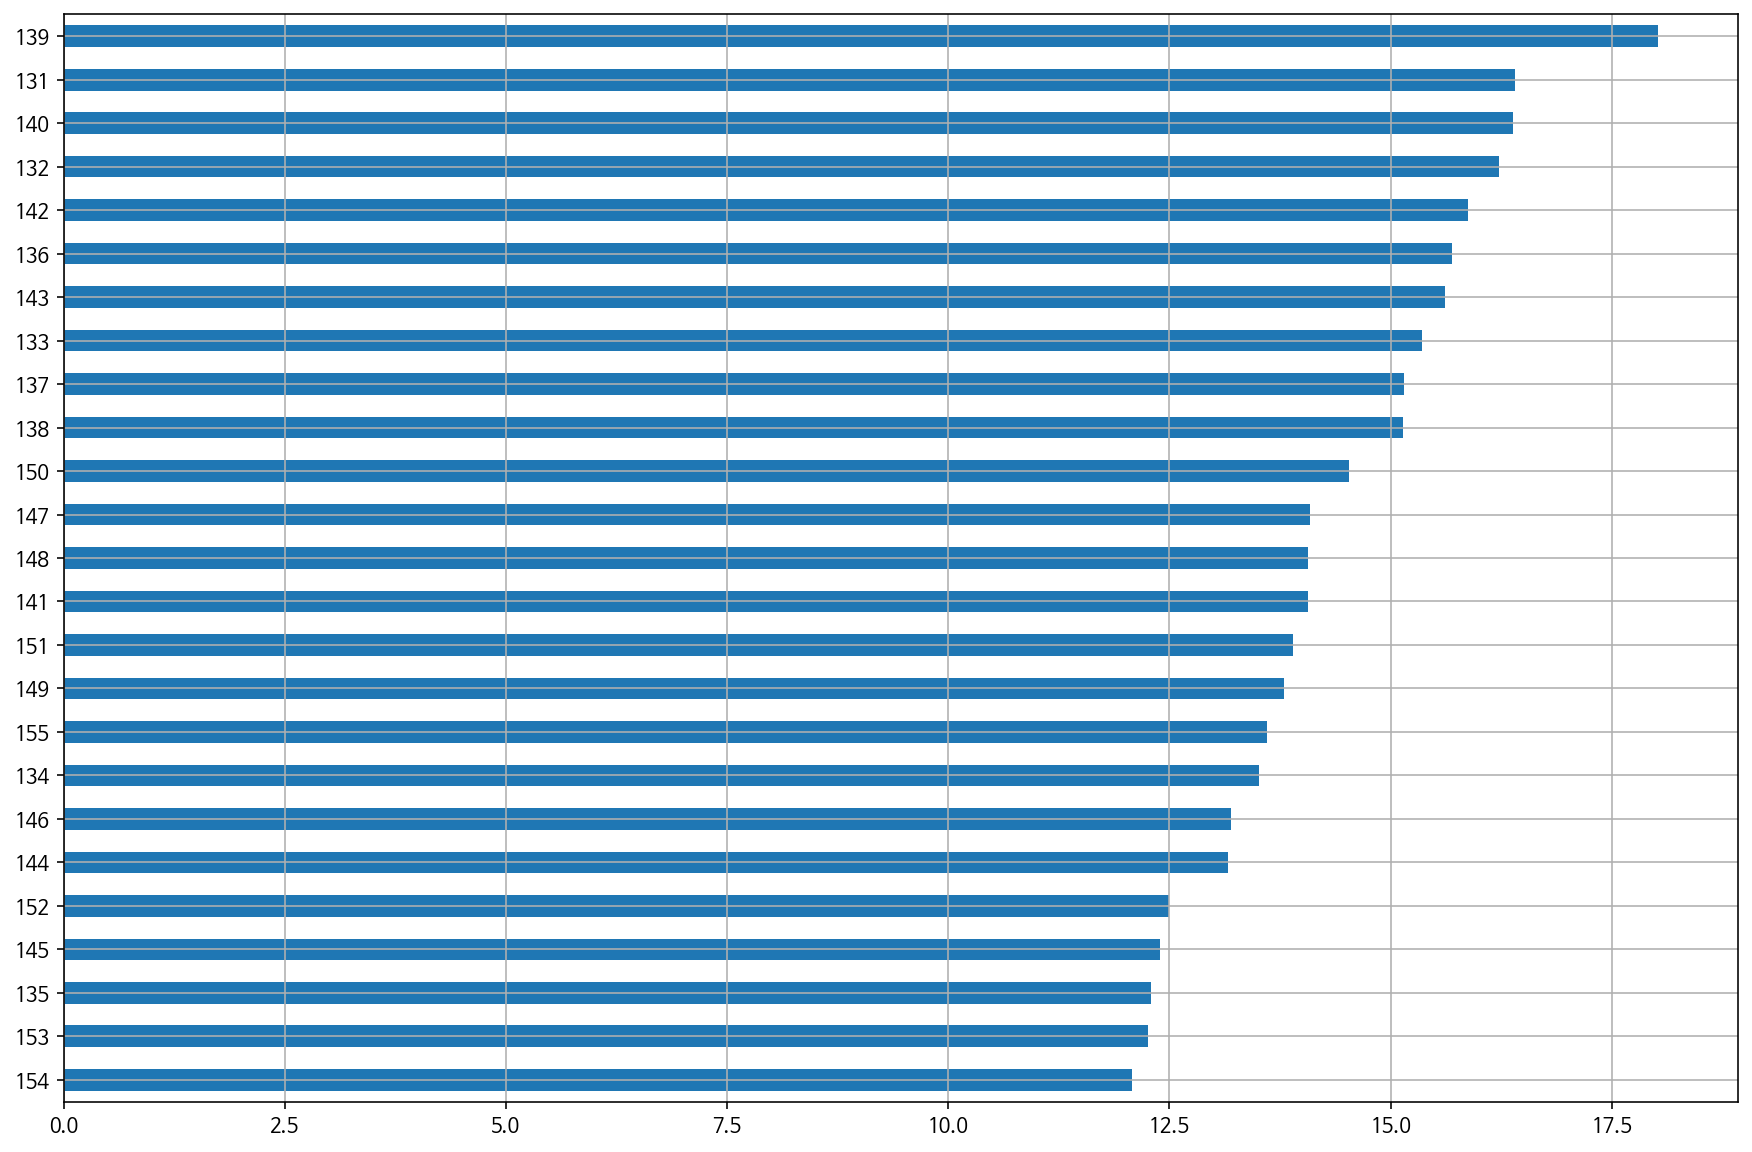

In [51]:
# bar chart로 그리기, Series로 그리기, 고령자비율을 기준으로

# 고령자 비율
tmp = s_pop_2018.sort_values('고령자비율', ascending=True)

# plt.figure( figsize = (15,10) )
# plt.bar(tmp.자치구, tmp.고령자비율)
# tmp['고령자비율'].plot( kind = "bar", rot = 45 )
tmp['고령자비율'].plot( kind = "barh", figsize = (15, 10), grid = True )
# 비교는 되지만 y축이 무엇인지 알 수 X → 자치구로 표현
# 인덱스값에 자치구가 들어가면 OK

In [52]:
# 인덱스 재지정
tmp.set_index( '자치구', inplace=True )
tmp.head(3)

,연도,세대수,총인구수,한국인,외국인,세대당인구,고령자(65),외국인비율,고령자비율
자치구,,,,,,,,,
송파구,2018,270866,673507,666635,6872,2.46,81364,1.020331,12.080647
강남구,2018,228775,547453,542364,5089,2.37,67085,0.929578,12.254020
광진구,2018,162606,371063,355559,15504,2.19,45619,4.178266,12.294139


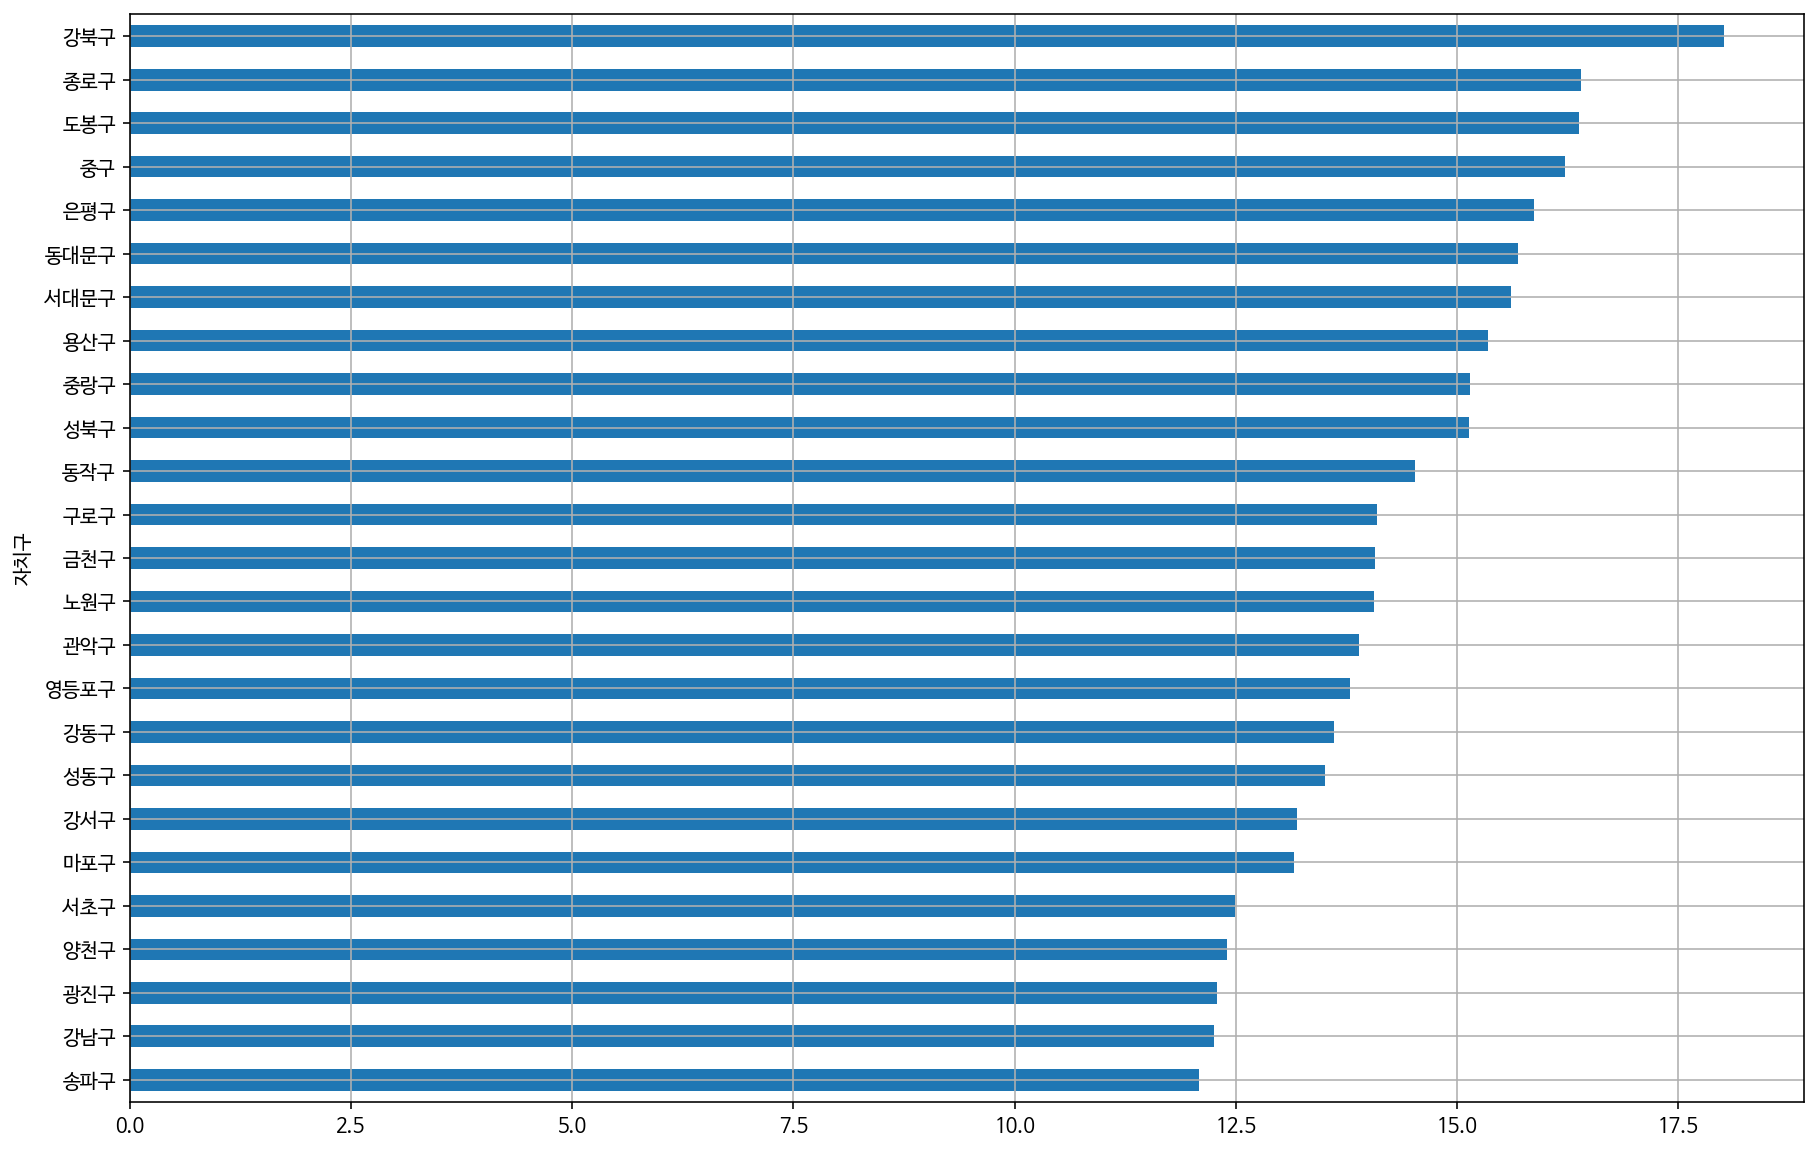

In [53]:
tmp['고령자비율'].plot( kind = "barh", figsize = (15, 10), grid = True )

## 인구현황과 CCTV를 병합
- s_pop, s_cctv를 한 개의 df로 구성
- merge(sql의 join), concat(단순 합치기)


In [54]:
# 2개의 데이터를 자치구 중심으로 병합
# 자치구 값들이 통일되어 있지 않음 → 전처리 대상(강남구 / 강 남 구)
s_pop_2018, s_cctv

(       연도   자치구     세대수    총인구수  ...  세대당인구  고령자(65)     외국인비율      고령자비율
 131  2018   종로구   73735  163026  ...   2.08    26742  6.110068  16.403518
 132  2018    중구   61502  135633  ...   2.04    22005  7.305007  16.223928
 133  2018   용산구  108974  245090  ...   2.10    37640  6.565343  15.357624
 134  2018   성동구  137209  316463  ...   2.25    42767  2.604412  13.514060
 135  2018   광진구  162606  371063  ...   2.19    45619  4.178266  12.294139
 136  2018  동대문구  161820  364338  ...   2.15    57165  4.470025  15.690101
 137  2018   중랑구  180511  408147  ...   2.23    61830  1.209858  15.148954
 138  2018   성북구  186601  447687  ...   2.34    67782  2.640014  15.140489
 139  2018   강북구  143395  322915  ...   2.23    58196  1.161606  18.022080
 140  2018   도봉구  138087  341649  ...   2.46    55964  0.654473  16.380554
 141  2018   노원구  217655  548160  ...   2.50    77096  0.804145  14.064507
 142  2018   은평구  205001  487666  ...   2.36    77420  0.916406  15.875620
 143  2018  서대문구  138549 

In [55]:
s_cctv["자치구"] = s_cctv["자치구"].apply( lambda x : str( x.replace( " ", "" ) ) )

In [56]:
tmp = pd.merge(s_pop_2018, s_cctv, on="자치구")

In [57]:
tmp.shape

(25, 20)

In [58]:
# 자치구를 인덱스로 설정
tmp = tmp.set_index( "자치구" )
tmp

,연도,세대수,총인구수,한국인,외국인,세대당인구,고령자(65),외국인비율,고령자비율,소계,2011년,2012년,2013년,2014년,2015년,2016년,2017년,2018년,증가분
자치구,,,,,,,,,,,,,,,,,,,
종로구,2018,73735,163026,153065,9961,2.08,26742,6.110068,16.403518,1471,8.0,7.0,599.0,132,195,148,281,101,56.323061
중구,2018,61502,135633,125725,9908,2.04,22005,7.305007,16.223928,1544,25.0,165.0,114.0,80,245,270,317,328,145.468998
용산구,2018,108974,245090,228999,16091,2.10,37640,6.565343,15.357624,2063,1279.0,152.0,201.0,107,102,89,60,73,12.058664
성동구,2018,137209,316463,308221,8242,2.25,42767,2.604412,13.514060,2679,665.0,109.0,118.0,101,258,201,933,294,114.148681
광진구,2018,162606,371063,355559,15504,2.19,45619,4.178266,12.294139,1581,470.0,42.0,83.0,87,64,21,468,346,111.930295
동대문구,2018,161820,364338,348052,16286,2.15,57165,4.470025,15.690101,2003,0.0,0.0,0.0,1326,111,233,136,197,39.387613
중랑구,2018,180511,408147,403209,4938,2.23,61830,1.209858,15.148954,1068,0.0,0.0,0.0,770,102,121,66,9,22.477064
성북구,2018,186601,447687,435868,11819,2.34,67782,2.640014,15.140489,3003,779.0,84.0,304.0,241,279,388,285,643,78.008299
강북구,2018,143395,322915,319164,3751,2.23,58196,1.161606,18.022080,1265,243.0,88.0,141.0,74,145,254,1,319,83.068017


In [59]:
tmp.shape

(25, 19)

- 정량(적) 분석 > 상관분석 > **피어슨 상관계수** 혹은 스피어만 상관계수를 이용한 관계분석 수행 可
- 상관계수 : 상관분석을 수행하기 위한 값, 척도 → numpy 사용
- 예시
  - 자치구 당 고령자비율과 소계(cctv 총 설치 개수)
  - 자치구 당 외국인비율과 소계(cctv 총 설치 개수)
  - 자치구 당 한국인과 소계(cctv 총 설치 개수)
  - 자치구 당 총인구수와 소계(cctv 총 설치 개수)

### 상관분석(Correlation Analysis)
- 두 변수 간의 관계를 알아보기 위해 수행
- 사용지표 : 상관계수(correlation coefficient)
  - 피어슨 상관계수(pearson correlation coefficient)
    - 등간 척도로 측정되는 두 변수 간의 상관관계 측정용 알고리즘(수학식)
    - numpy.corrcoef() 함수
  - 스피어만 상관계수(spearman correlation coefficient)
    - 서열 척도


- 해석
  - 상관계수는 -1 ~ 1로 나온다
  - -1이나 1에 가까울수록 상관관계가 높음
  - 주의사항 : 상관계수가 높다고 인과관계가 성립되는 것은 아니다
  - 안경을 쓰는 비율과 성적 비율에 대한 상관분석을 했더니 90% → 안경을 쓰면 공부를 잘 한다고 말할 수는 없음
- 부호
  - 상관계수값의 부호가 -인 경우
    - 두 변수가 상반된 방향, 반대 방향으로 영향을 미침
    - 하나가 증가하면, 하나는 감소
  - 상관계수값의 부호가 +인 경우
    - 두 변수가 같은 방향으로 영향을 미침
    - 하나가 증가하면, 남은 하나도 증가
- 크기
  - 상관계수값이 0 → 두 변수는 독립적
  - 상관값이 클수록 같이 변화하는 영향성 大
  - 비율계산
    - ex)
      - -0.40379375 ** 2 → 0.1630493925390625 → 16%로 크기를 설명 可(관련성)   
      → x(고령자 비율)의 분산 중 16%만 y(cctv소계)에 영향을 미침(공유,설명됨)

In [60]:
# 자치구 당 고령자비율과 소계
tmp1 = np.corrcoef( tmp['고령자비율'], tmp["소계"] )
tmp1

array([[ 1.        , -0.40379375],
       [-0.40379375,  1.        ]])

In [61]:
tmp1[0][1], np.sum( np.tril( tmp1, k =-1 ) )

(-0.40379374828054787, -0.4037937482805478)

In [62]:
newData = tmp

In [63]:
# 실습
def s_pct( k = '고령자비율' ) :
  pct = (np.corrcoef( tmp[ k ], tmp["소계"] )[0][1])**2 * 100
  if np.corrcoef( tmp[ k ], tmp["소계"] )[0][1] < 0 :
    return -1 * pct
  else :
    return pct

s_pct(), s_pct('외국인비율'), s_pct('한국인'), s_pct('총인구수')

(-16.304939115045446,
 -0.1716554658340753,
 12.81821891731142,
 14.079910352018214)

In [64]:
# 강의
def corrcoefRate( x, y ) :
  ttmp = np.corrcoef( x, y )
  # 2x2 배열(행렬)인 경우에만 해당 (-1이란 값은)
  v    = np.sum(np.tril( ttmp, k=-1 ))
  return {
      'value' : v*v, 
      'sign'  : '+' if v>0 else '-'
  }

# 자치구 당 고령자비율과 소계(cctv 총 설치 개수)
print( corrcoefRate( tmp['고령자비율'], tmp['소계'] ) )
# 자치구당 외국인비율과 소계(cctv총 설치대수)
print( corrcoefRate( newData['외국인비율'], newData['소계'] ) )
# 외국인 비율의 분산의 0.1%가 음의 방향으로 영향을 미친다. 거의 0에 가까우므로 상관없다(독립적이다)
# 자치구당 한국인과 소계(cctv총 설치대수)
print( corrcoefRate( newData['한국인'], newData['소계'] ) )
# 자치구당 총인구수과 소계(cctv총 설치대수)
print( corrcoefRate( newData['총인구수'], newData['소계'] ) )
# 자치구가 cctv를 설치할때 인구수는 14%내외로 고려한다라고도 해석할수 있다
# 조금더 정확하게 할려면 인구 증가분으로 보는게 나을듯
# 총인구수의 분산중 14%가 cctv를 설치할때 영향을 미친다(x의 분산중 14%가 y로 설명된다)
# 이것은 약한 상관관계로 보인다.

{'value': 0.16304939115045441, 'sign': '-'}
{'value': 0.001716554658340753, 'sign': '-'}
{'value': 0.12818218917311414, 'sign': '+'}
{'value': 0.14079910352018213, 'sign': '+'}


### 척도
- 사회, 심리학 등에 통계 용도로 사용
- 명도척도, 서열척도, 등간척도, 비율척도
  - 명도
    - 명칭이 들어갈 자리에 숫자 부여
    - 속성만 다를 뿐
    - 통계 : 비모수통계, 빈도분석, 교차분석, ...
    - 예) 학년(1학년, 2학년, 3학년, ...), 축구선수(7번, 10번, ...), 성별(여2, 남1)
  - 서열(스피어만)
    - 대상을 구분해주는 명도척도의 특성에서, 대상에 대한 순위관계(서열)가 정보로 들어가는 척도
    - 통계 : 비모수통계, 서열상관관계
    - 예) 순위(1등, 2등, 3등), 키순서(170, 180, 190cm)
  - 등간(피어슨)
    - 명도척도, 서열척도 정보에, 속성 간의 차이가 동일하다(간격)는 정보를 추가
    - 통계 : 모수통계
    - 예) 월드컵 개최 : 2002, 2006, 2010, ...  / 올림픽 개최 : 2000, 2004, 2008, ... → 4년 주기
  - 비율
    - 앞의 3개를 포함하면서 비율에 대한 정보가 포함
    - 통계 : 모수통계
    - 예) A가 50kg, B가 60kg라면 B는 A보다 10kg 더 나감

### 시각화

- 소계 및 인구수를 바차트 표현(수평)

In [65]:
newData = tmp

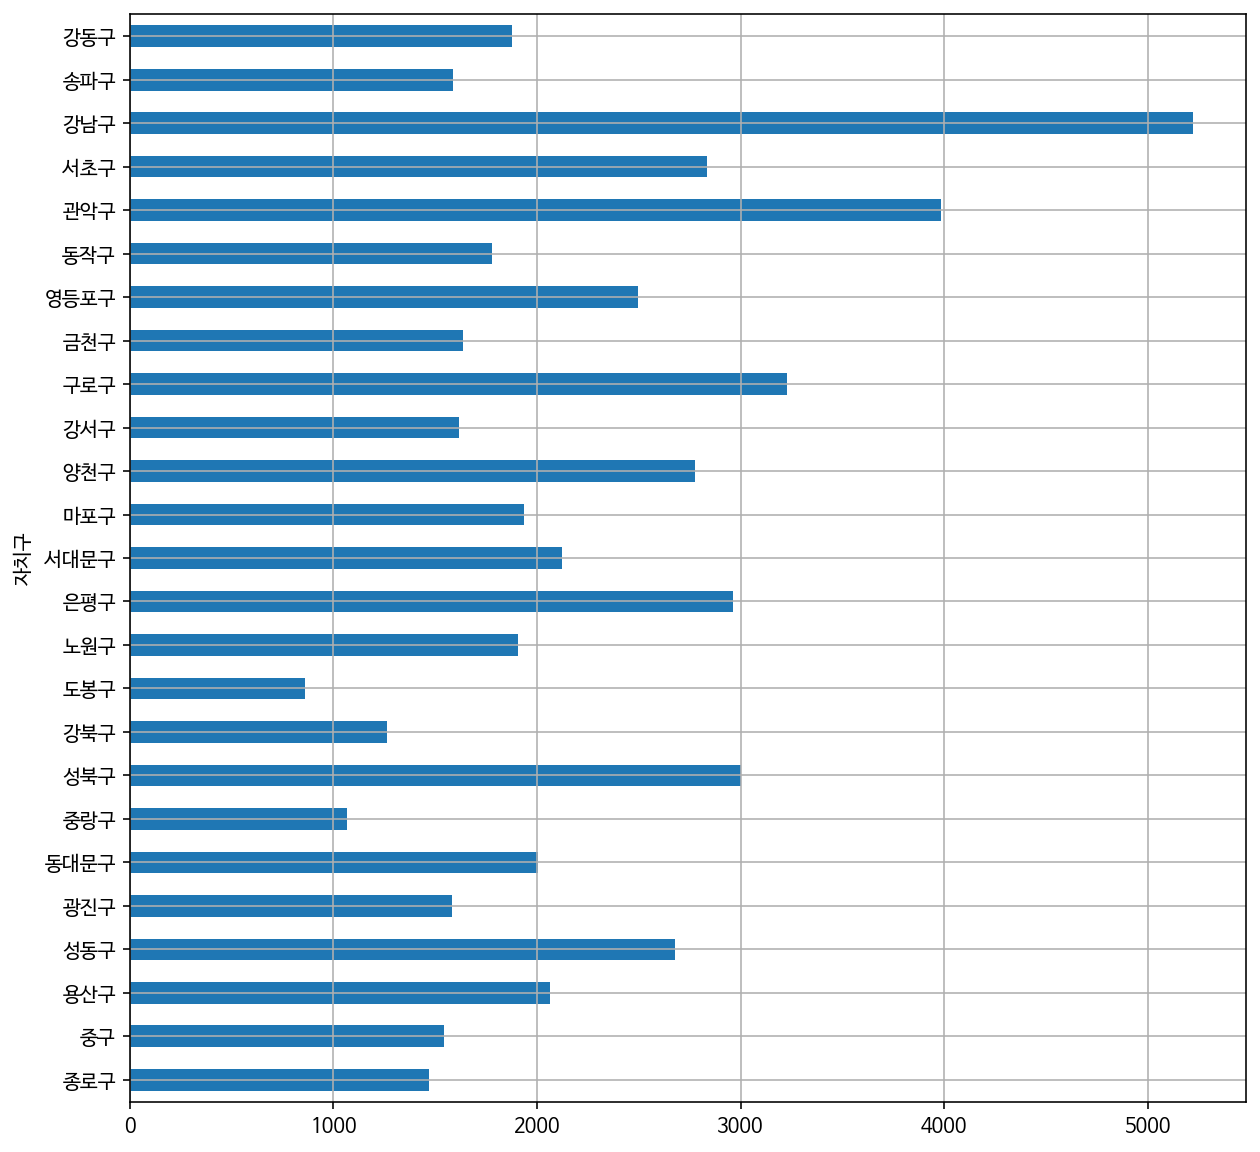

In [66]:
newData['소계'].plot(kind = 'barh', grid = True, figsize = (10, 10))

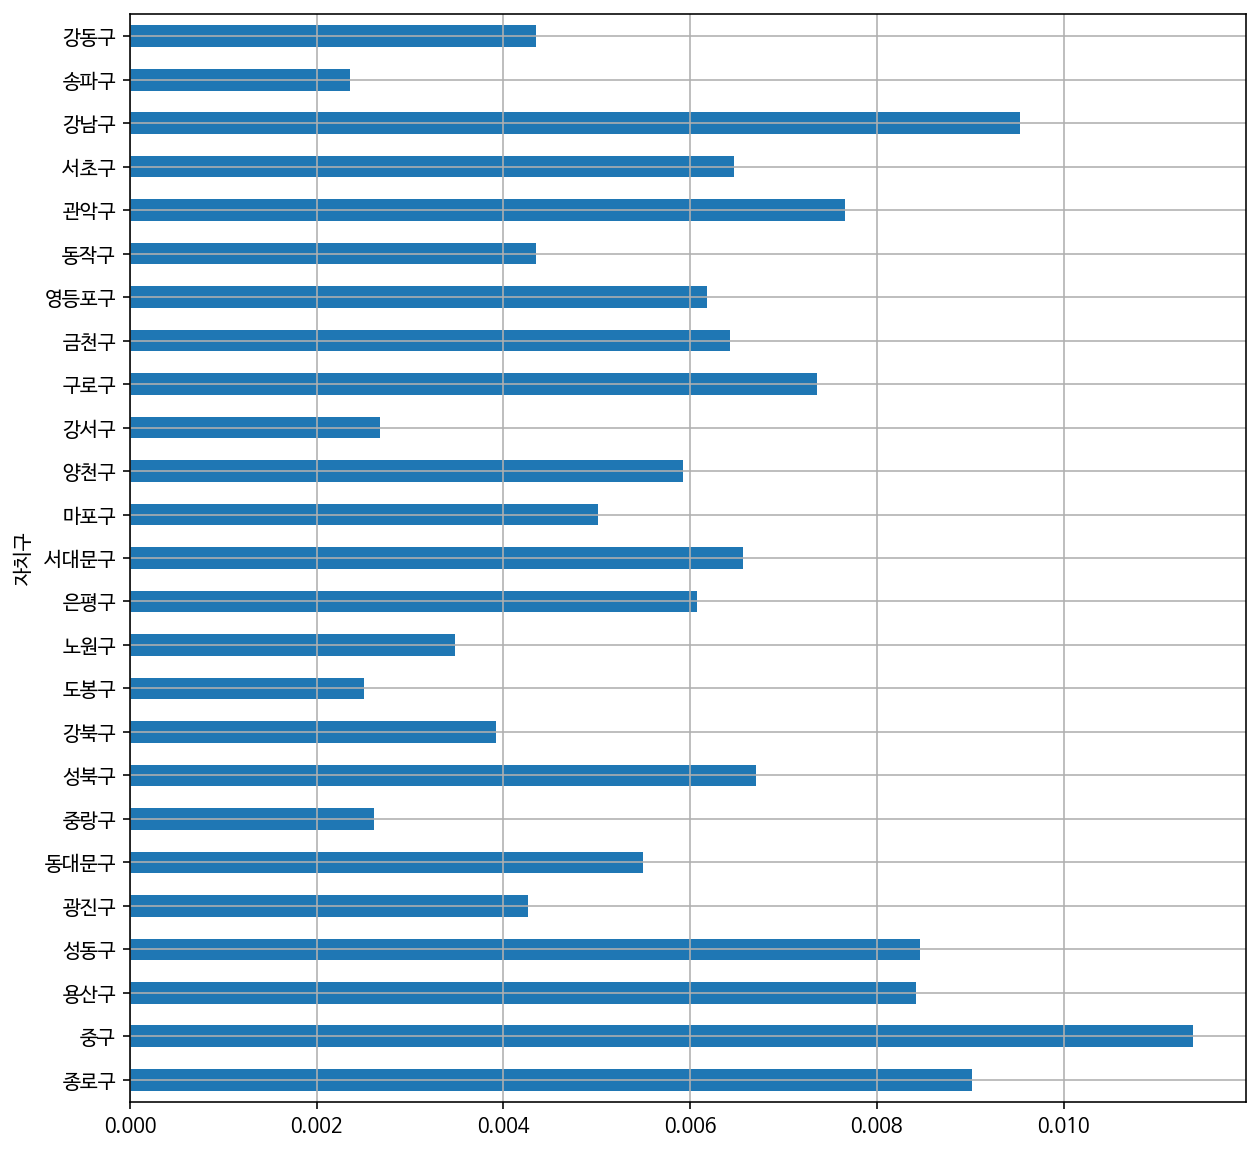

In [67]:
# 총인구수 대비 소계 값을 bar chart로 표현
# 소계/총인구수 → 인구 1인당 cctv가 몇 개인가
# 변수를 직접 생성해서 바로 시각화 처리

tmp = newData['소계'] / newData['총인구수']
tmp.plot(kind = 'barh', grid = True, figsize = (10, 10))

<Figure size 432x288 with 0 Axes>

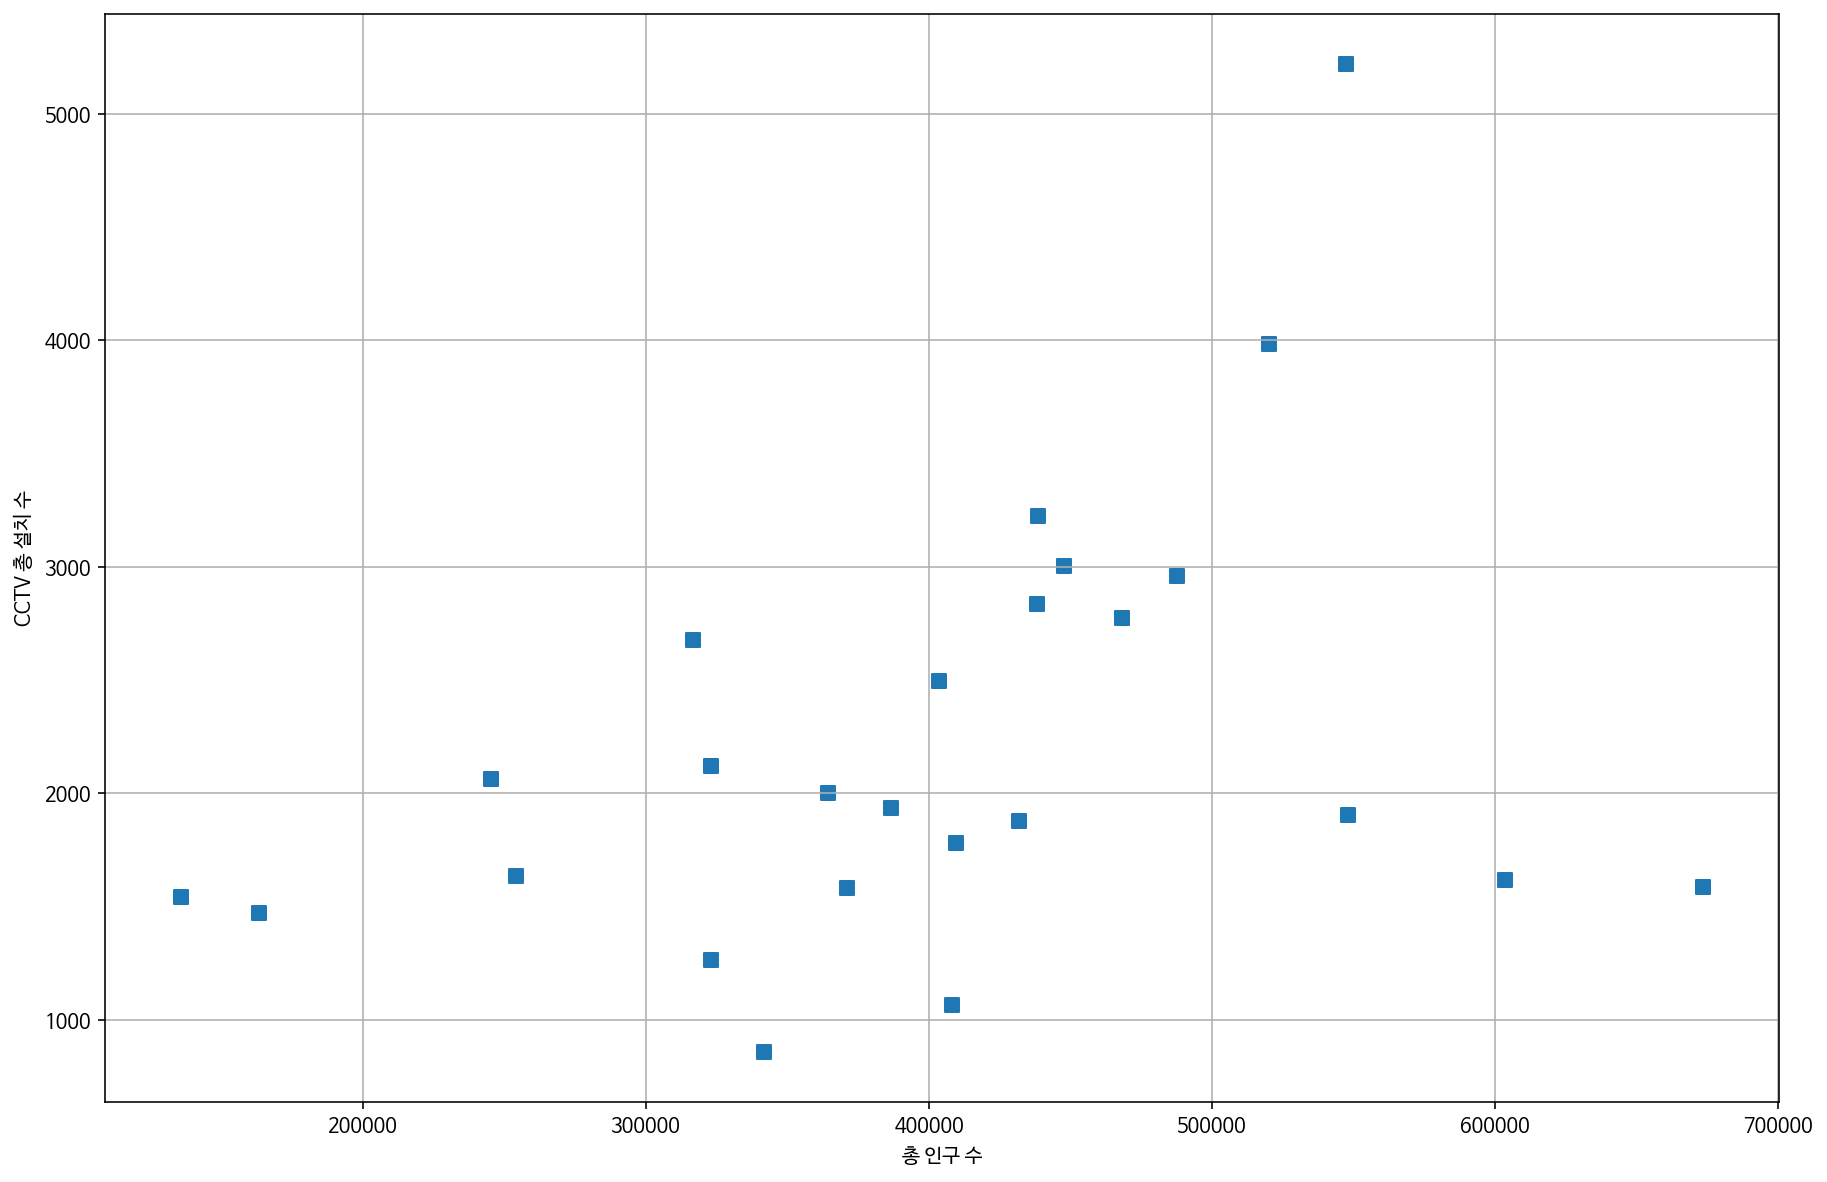

In [68]:
# 산점도, 산포도 데이터 분포 확인
plt.figure()
plt.figure( figsize = (15, 10) )
plt.scatter( newData['총인구수'], newData['소계'], s = 50, marker = "s" )
plt.xlabel('총 인구 수')
plt.ylabel('CCTV 총 설치 수')
plt.grid()
plt.show()
# 두 변수 간의 관계를 식으로 표현할 수 있는가 → 기울기
# y = ax + b ← 1차 함수 (딥러닝식 표현 : y = x\ + b), 2차, 3차, ...
# 두 변수를 1차함수로 표현할 수 있는가 → 그 식을 찾아보자 → 평균점
# 그 위에 있는 포인트와 그 ㅏ래 있는 포인트에 대한 해석 可

In [69]:
# numpy에서 지원
# 총 인구수와 소계 간의 설명할 수 있는 기울기가 직석인 함수을 찾는 방법 → 1차 함수 형태
fp1 = np.polyfit( newData['총인구수'], newData['소계'], deg = 1 )
fp1
# [ a = 기울기, b = 절편 ] : y = ax + b

array([2.85240371e-03, 1.07309855e+03])

In [70]:
# 함수 생성
f1 = np.poly1d( fp1 )

# x 준비
fx = np.linspace( 100000, 700000, 100 )
fx 

array([100000.        , 106060.60606061, 112121.21212121, 118181.81818182,
       124242.42424242, 130303.03030303, 136363.63636364, 142424.24242424,
       148484.84848485, 154545.45454545, 160606.06060606, 166666.66666667,
       172727.27272727, 178787.87878788, 184848.48484848, 190909.09090909,
       196969.6969697 , 203030.3030303 , 209090.90909091, 215151.51515152,
       221212.12121212, 227272.72727273, 233333.33333333, 239393.93939394,
       245454.54545455, 251515.15151515, 257575.75757576, 263636.36363636,
       269696.96969697, 275757.57575758, 281818.18181818, 287878.78787879,
       293939.39393939, 300000.        , 306060.60606061, 312121.21212121,
       318181.81818182, 324242.42424242, 330303.03030303, 336363.63636364,
       342424.24242424, 348484.84848485, 354545.45454545, 360606.06060606,
       366666.66666667, 372727.27272727, 378787.87878788, 384848.48484848,
       390909.09090909, 396969.6969697 , 403030.3030303 , 409090.90909091,
       415151.51515152, 4

<Figure size 432x288 with 0 Axes>

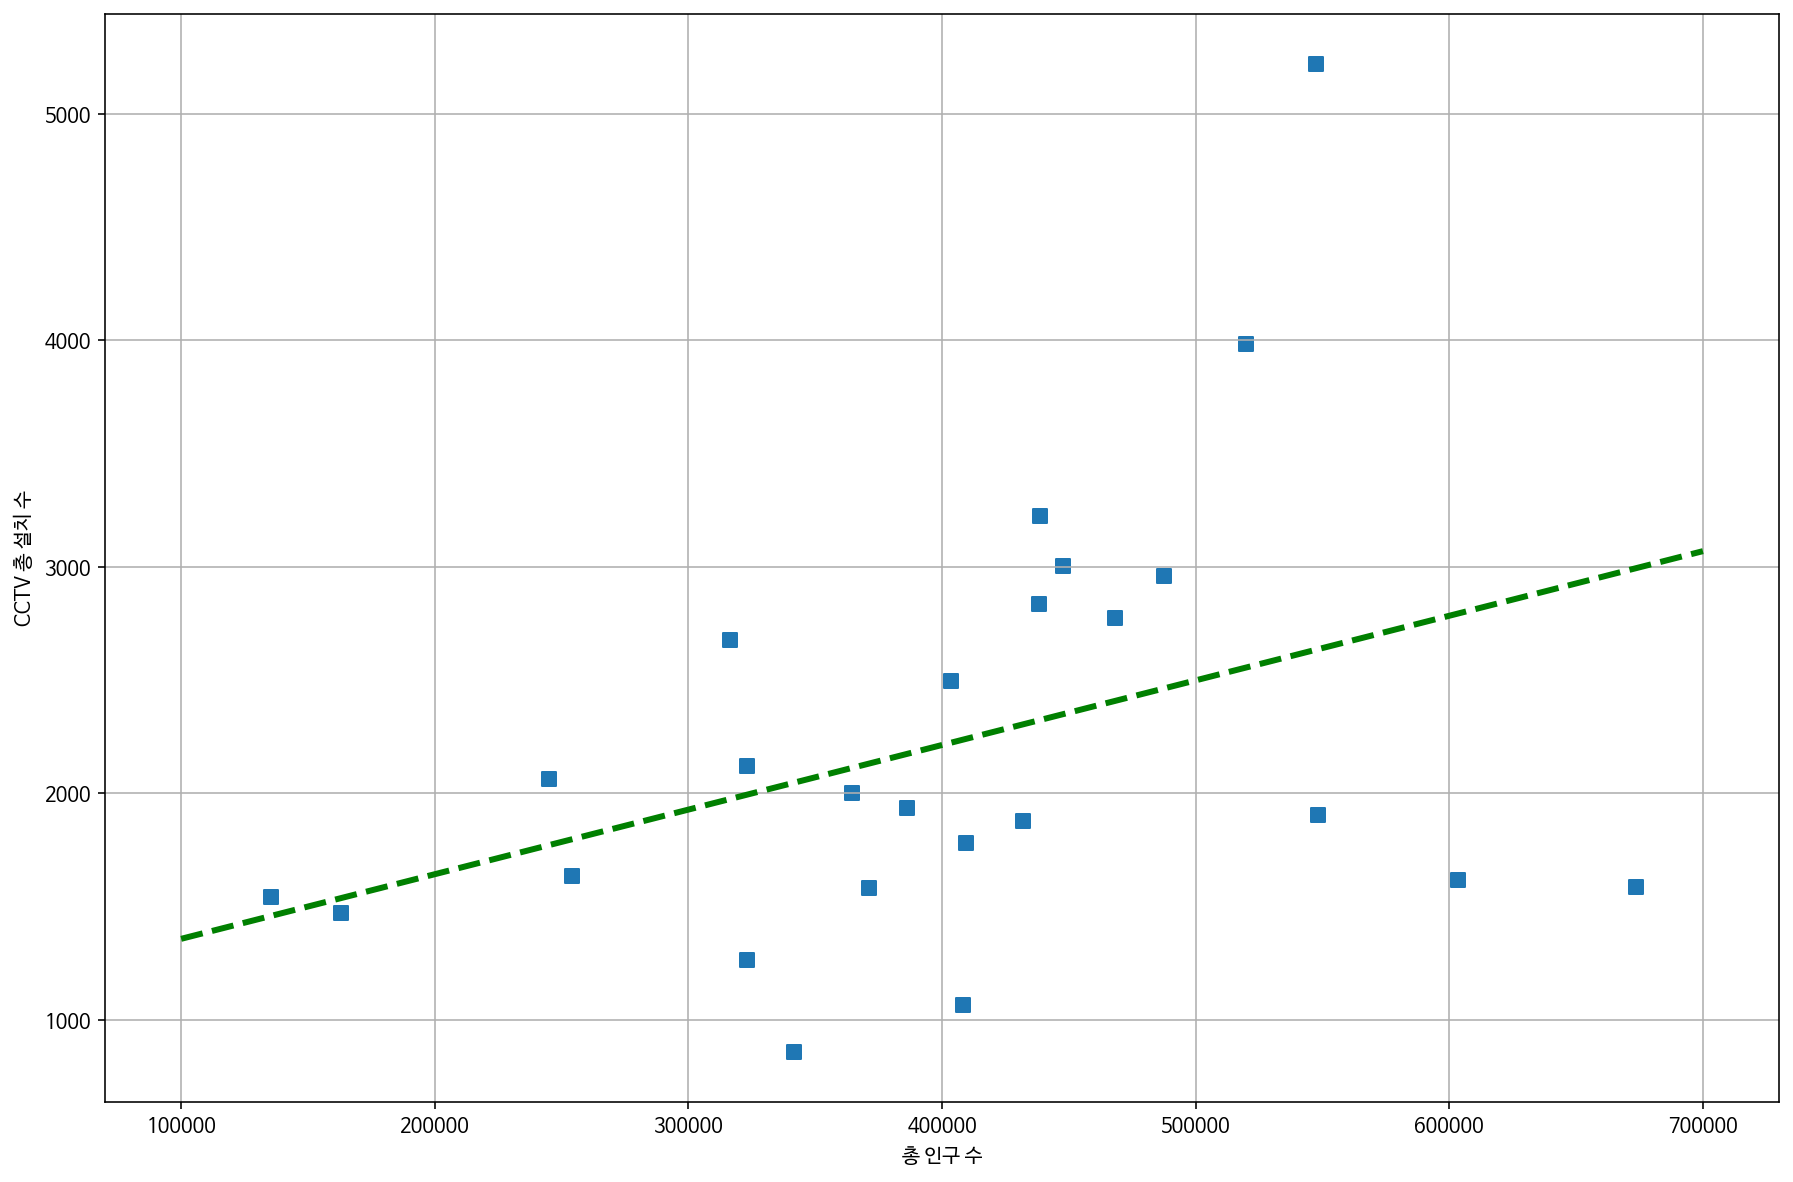

In [71]:
plt.figure()
plt.figure( figsize = (15, 10) )
plt.scatter( newData['총인구수'], newData['소계'], s = 50, marker = "s" )

# 1차 함수를 플로팅
plt.plot( fx, f1( fx ), ls = 'dashed', lw = 3, color = "g" )

plt.xlabel('총 인구 수')
plt.ylabel('CCTV 총 설치 수')
plt.grid()
plt.show()

# 1차 함수 라인보다 아래에 있는 자치구는 CCTV를 더 설치해야 될 것, 반대쪽은 더 늘릴 필요가 X고 해석 可 
# 전제 : CCTV 설치 요인이 인구에만 편중된다면 가능한 해석, 다른 요인이 있다면 검토 必 → 범죄 데이터를 살펴보겠음
# 함수로 표현된 값, 포인트 간의 거리 : 절대값 → 오차율

In [72]:
# 오차율 계산
# np.abs( 소계 - f1(인구수) )
newData['오차율'] = np.abs( newData['소계'] - f1(newData['총인구수']) )
newData.head()

,연도,세대수,총인구수,한국인,외국인,세대당인구,고령자(65),외국인비율,고령자비율,소계,2011년,2012년,2013년,2014년,2015년,2016년,2017년,2018년,증가분,오차율
자치구,,,,,,,,,,,,,,,,,,,,
종로구,2018,73735,163026,153065,9961,2.08,26742,6.110068,16.403518,1471,8.0,7.0,599.0,132,195,148,281,101,56.323061,67.114515
중구,2018,61502,135633,125725,9908,2.04,22005,7.305007,16.223928,1544,25.0,165.0,114.0,80,245,270,317,328,145.468998,84.021380
용산구,2018,108974,245090,228999,16091,2.10,37640,6.565343,15.357624,2063,1279.0,152.0,201.0,107,102,89,60,73,12.058664,290.805827
성동구,2018,137209,316463,308221,8242,2.25,42767,2.604412,13.514060,2679,665.0,109.0,118.0,101,258,201,933,294,114.148681,703.221217
광진구,2018,162606,371063,355559,15504,2.19,45619,4.178266,12.294139,1581,470.0,42.0,83.0,87,64,21,468,346,111.930295,550.520026


In [73]:
# 오차율 높은 순으로 정렬
newData.sort_values( by = '오차율', ascending=False ).head()

,연도,세대수,총인구수,한국인,외국인,세대당인구,고령자(65),외국인비율,고령자비율,소계,2011년,2012년,2013년,2014년,2015년,2016년,2017년,2018년,증가분,오차율
자치구,,,,,,,,,,,,,,,,,,,,
강남구,2018,228775,547453,542364,5089,2.37,67085,0.929578,12.254020,5221,1944.0,195.0,316.0,430,546,765,577,448,52.171379,2586.344483
관악구,2018,262222,520040,501957,18083,1.91,72249,3.477233,13.892970,3985,430.0,56.0,419.0,487,609,619,694,671,99.150425,1428.537426
송파구,2018,270866,673507,666635,6872,2.46,81364,1.020331,12.080647,1586,600.0,99.0,88.0,21,166,100,116,396,62.833676,1408.212414
도봉구,2018,138087,341649,339413,2236,2.46,55964,0.654473,16.380554,858,197.0,66.0,8.0,185,59,155,117,71,66.601942,1189.619423
강서구,2018,258503,603611,596949,6662,2.31,79660,1.103691,13.197241,1617,219.0,155.0,118.0,230,187,190,264,254,77.887789,1177.840805


<Figure size 432x288 with 0 Axes>

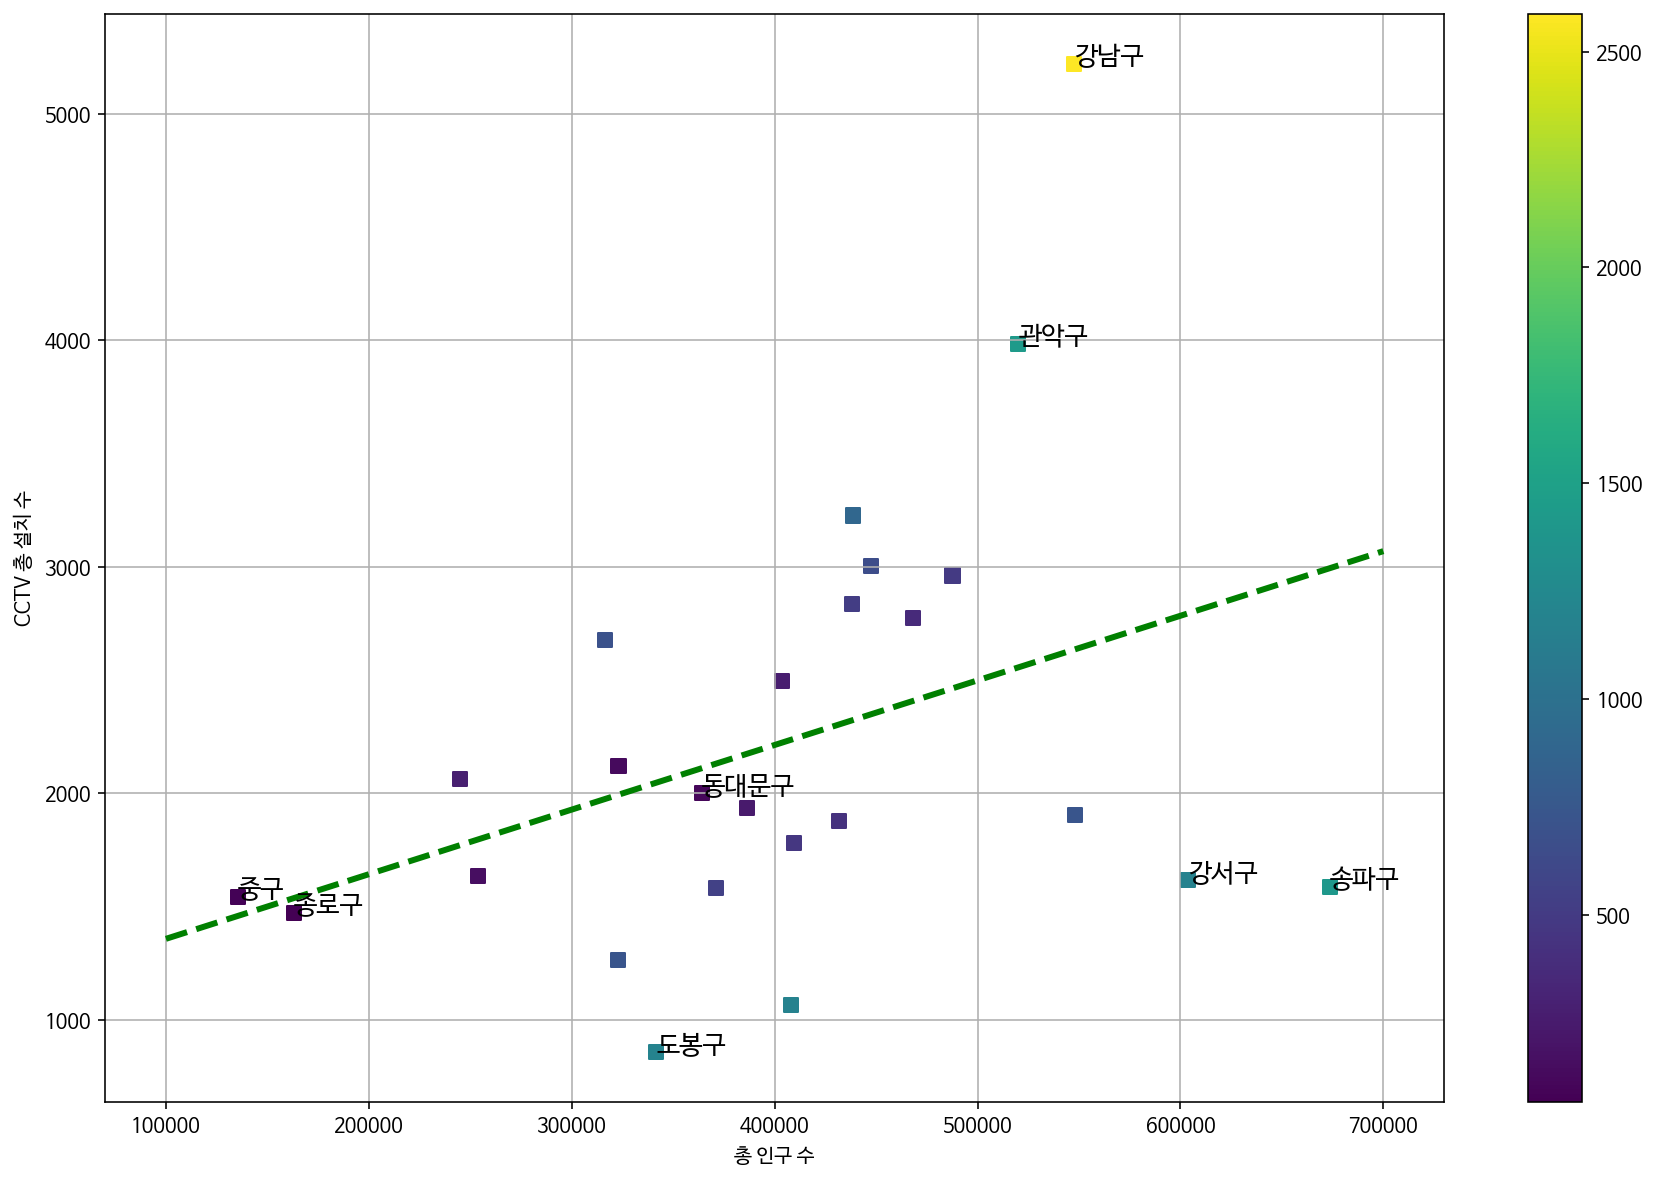

In [74]:
# 오차율 colormap으로 사용
# 실습

plt.figure()
plt.figure( figsize = (15, 10) )
plt.scatter( newData['총인구수'], newData['소계'], c = newData['오차율'], s = 50, marker = "s" )
# 1차 함수를 플로팅
plt.plot( fx, f1( fx ), ls = 'dashed', lw = 3, color = "g" )
plt.xlabel('총 인구 수')
plt.ylabel('CCTV 총 설치 수')

# 각 포인트에 자치구 표시
# plt.text( 400000, 4000, '강남구', fontsize=10 )
# 오차율이 큰 자치구 5개 표시
for i in range(0, 5) :
  plt.text( 
      newData.sort_values( by = '오차율', ascending=False )['총인구수'][i], 
      newData.sort_values( by = '오차율', ascending=False )['소계'][i], 
      newData.sort_values( by = '오차율', ascending=False ).index[i], 
      fontsize=13 
      )
# 오차율이 작은 자치구 3개 표시
for i in range(0, 3) :
  plt.text( 
      newData.sort_values( by = '오차율')['총인구수'][i], 
      newData.sort_values( by = '오차율')['소계'][i], 
      newData.sort_values( by = '오차율').index[i], 
      fontsize=13
      )
  
plt.colorbar()
plt.grid()
plt.show()

In [75]:
# 강의
# enumerate(newData)는 여기와는 안 맞음
for n in enumerate(newData) :
  print(n)

(0, '연도')
(1, '세대수')
(2, '총인구수')
(3, '한국인')
(4, '외국인')
(5, '세대당인구')
(6, '고령자(65)')
(7, '외국인비율')
(8, '고령자비율')
(9, '소계')
(10, '2011년')
(11, '2012년')
(12, '2013년')
(13, '2014년')
(14, '2015년')
(15, '2016년')
(16, '2017년')
(17, '2018년')
(18, '증가분')
(19, '오차율')


In [76]:
# 텍스트로 그려야할 대상 추출
tmp = newData.sort_values( by = "오차율", ascending = False)
tmp = pd.concat ( [ tmp[:5], tmp[-3:] ] )

In [77]:
tmp.shape

(8, 20)

In [78]:
for n in enumerate(tmp.index) :
  print(n)

(0, '강남구')
(1, '관악구')
(2, '송파구')
(3, '도봉구')
(4, '강서구')
(5, '동대문구')
(6, '중구')
(7, '종로구')


In [79]:
for idx, gu in enumerate(tmp.index) :
  # print(idx, gu, '인구수 :', tmp['총인구수'][idx])
  # print(idx, gu, '인구수 :', tmp['총인구수'][idx], tmp.index[idx])
  print( 'x=%-10s y=%4s : 이름%5s' % (tmp['총인구수'][idx], tmp['소계'][idx], tmp.index[idx]) )
  # print( idx, gu, '인구수', tmp.loc[ , ], tmp.iloc[ , ], tmp[][] ) → 이런 방법도 존재

x=547453     y=5221 : 이름  강남구
x=520040     y=3985 : 이름  관악구
x=673507     y=1586 : 이름  송파구
x=341649     y= 858 : 이름  도봉구
x=603611     y=1617 : 이름  강서구
x=364338     y=2003 : 이름 동대문구
x=135633     y=1544 : 이름   중구
x=163026     y=1471 : 이름  종로구


<Figure size 432x288 with 0 Axes>

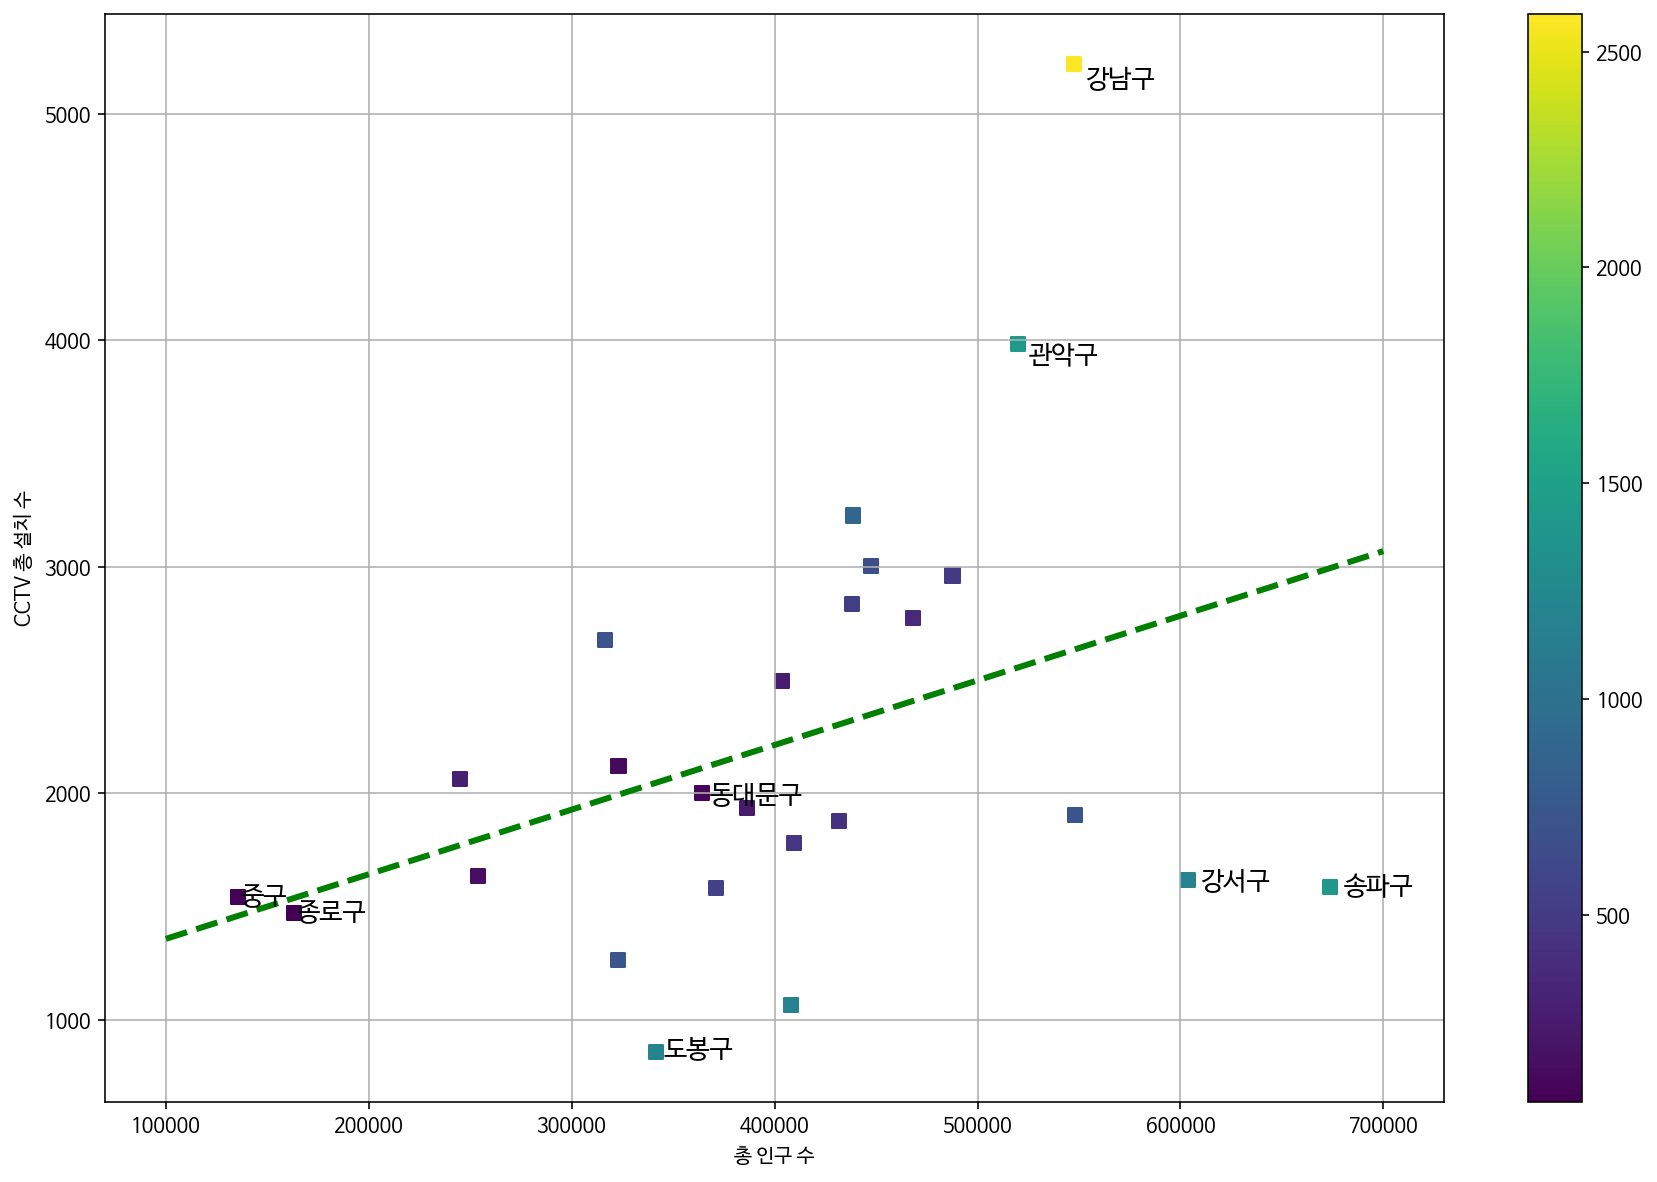

In [80]:
# 오차율 colormap으로 사용

plt.figure()
plt.figure( figsize = (15, 10) )
plt.scatter( newData['총인구수'], newData['소계'], c = newData['오차율'], s = 50, marker = "s" )
# 1차 함수를 플로팅
plt.plot( fx, f1( fx ), ls = 'dashed', lw = 3, color = "g" )
plt.xlabel('총 인구 수')
plt.ylabel('CCTV 총 설치 수')

# 각 포인트에 자치구 표시
# plt.text( 400000, 4000, '강남구', fontsize=10 )
for idx, gu in enumerate(tmp.index):
  # x, y, name = ( tmp['총인구수'][idx], tmp['소계'][idx], tmp.index[idx] )
  # plt.text( x, y, name, fontsize=15 )
  x, y = ( tmp['총인구수'][idx], tmp['소계'][idx] ) # 좀더 간결하게 표현
  # 포인트에 글자가 겹치므로, 않겹치게 위치 조정 x축으로 1%증가, y축으로는 2
  plt.text( x*1.01, y*0.98, gu, fontsize=13 )

# 오차율이 큰 자치구 5개 표시

# 오차율이 작은 자치구 3개 표시
  
plt.colorbar()
plt.grid()
plt.show()

In [81]:
newData

,연도,세대수,총인구수,한국인,외국인,세대당인구,고령자(65),외국인비율,고령자비율,소계,2011년,2012년,2013년,2014년,2015년,2016년,2017년,2018년,증가분,오차율
자치구,,,,,,,,,,,,,,,,,,,,
종로구,2018,73735,163026,153065,9961,2.08,26742,6.110068,16.403518,1471,8.0,7.0,599.0,132,195,148,281,101,56.323061,67.114515
중구,2018,61502,135633,125725,9908,2.04,22005,7.305007,16.223928,1544,25.0,165.0,114.0,80,245,270,317,328,145.468998,84.021380
용산구,2018,108974,245090,228999,16091,2.10,37640,6.565343,15.357624,2063,1279.0,152.0,201.0,107,102,89,60,73,12.058664,290.805827
성동구,2018,137209,316463,308221,8242,2.25,42767,2.604412,13.514060,2679,665.0,109.0,118.0,101,258,201,933,294,114.148681,703.221217
광진구,2018,162606,371063,355559,15504,2.19,45619,4.178266,12.294139,1581,470.0,42.0,83.0,87,64,21,468,346,111.930295,550.520026
동대문구,2018,161820,364338,348052,16286,2.15,57165,4.470025,15.690101,2003,0.0,0.0,0.0,1326,111,233,136,197,39.387613,109.337611
중랑구,2018,180511,408147,403209,4938,2.23,61830,1.209858,15.148954,1068,0.0,0.0,0.0,770,102,121,66,9,22.477064,1169.298565
성북구,2018,186601,447687,435868,11819,2.34,67782,2.640014,15.140489,3003,779.0,84.0,304.0,241,279,388,285,643,78.008299,652.917392
강북구,2018,143395,322915,319164,3751,2.23,58196,1.161606,18.022080,1265,243.0,88.0,141.0,74,145,254,1,319,83.068017,729.182492


In [82]:
newData.shape

(25, 20)

In [83]:
# 백업(.csv 적재)
# newData.to_csv('./pop_cctv_mid_analysis.csv')
newData.to_csv('/content/drive/My Drive/2020_AI_Busan/1_Analysis/data/pop_cctv_mid_analysis.csv', sep=',', encoding='utf-8')

# 데이터 모델 구축

# 시스템 통합